In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tqdm

In [3]:
class SurnameDataset(Dataset): #torch.utils.data.Dataset을 상속함.
  def __init__(self, surname_df, vectorizer):
    self.surname_df = surname_df
    self._vectorizer = vectorizer

    self.train_df = self.surname_df[self.surname_df.split == "train"]
    self.train_size = len(self.train_df)

    self.val_df = self.surname_df[self.surname_df.split == "val"]
    self.validation_size = len(self.val_df)

    self.test_df = self.surname_df[self.surname_df.split == "test"]
    self.test_size = len(self.test_df)

    self._lookup_dict = {
        "train": (self.train_df, self.train_size),
        "val": (self.val_df, self.validation_size),
        "test": (self.test_df, self.test_size)
    }
    self.set_split("train")

    class_counts = surname_df.nationality.value_counts().to_dict()
    def sort_key(item):
      return self._vectorizer.nationality_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

  @classmethod
  def load_dataset_and_make_vectorizer(cls, surname_csv):
    surname_df = pd.read_csv(surname_csv)
    train_surname_df = surname_df[surname_df.split=="train"]
    print(surname_df.head())
    return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
    surname_df = pd.read_csv(surname_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(surname_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return SurnameVectorizer.from_serializable(json.load(fp))

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def __len__(self):
    return self._target_size

  #이전 FFNN에서 변경된 부분. CNN의 경우 원핫 벡터가아닌 원핫 매트릭스를 반환해야함.
  def __getitem__(self, index):
    row = self._target_df.iloc[index]

    surname_matrix = \
      self._vectorizer.vectorize(row.surname)

    nationality_index = \
      self._vectorizer.nationality_vocab.lookup_token(row.nationality)

    return {
        "x_surname": surname_matrix,
        "y_nationality": nationality_index
    }

  def get_num_batches(self, batch_size):
    return len(self) // batch_size


In [14]:
class SurnameVectorizer():
  def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
    self.surname_vocab = surname_vocab #문자 -> 정수 mapping - Vocabulary 객체 저장
    self.nationality_vocab = nationality_vocab #국적 -> 정수 mapping
    self._max_surname_length = max_surname_length

  #CNN은 입력을 매트릭스로 반환
  def vectorize(self, surname):
    one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
    one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)

    for position_index, character in enumerate(surname):
      character_index = self.surname_vocab.lookup_token(character)
      one_hot_matrix[character_index][position_index] = 1
      #one_hot의 차원이 2번째임. 주의할 것.
    return one_hot_matrix

  #dataframe 함수 변경
  @classmethod
  def from_dataframe(cls, surname_df):
    surname_vocab = Vocabulary(unk_token="@")
    nationality_vocab = Vocabulary(add_unk=False)
    max_surname_length = 0
    for index, row in surname_df.iterrows():
      #최대 길이 구하기 알고리즘. (dynamic programming)
      max_surname_length = max(max_surname_length, len(row.surname))
      for letter in row.surname:
        #스펠링 하나마다 파이프에 집어넣음. 위치정보는 무시됨.
        surname_vocab.add_token(letter)
      nationality_vocab.add_token(row.nationality)
    return cls(surname_vocab, nationality_vocab, max_surname_length)

  @classmethod
  def from_serializable(cls, contents):
    surname_vocab = Vocabulary.from_serializable(contents["surname_vocab"])
    nationality_vocab = Vocabulary.from_serializable(contents["nationality_vocab"])
    return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

  def to_serializable(self):
    return {'surname_vocab': self.surname_vocab.to_serializable(),
      'nationality_vocab': self.nationality_vocab.to_serializable()}

In [5]:
class Vocabulary():
  def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx

    self._idx_to_token = {idx: token
                          for token, idx in self._token_to_idx.items()}
    self._add_unk = add_unk
    self._unk_token = unk_token

    self.unk_index = -1
    if add_unk:
      self.unk_index = self.add_token(unk_token)

  def to_serializable(self):
    return {
        "token_to_idx": self._token_to_idx,
        "add_unk": self._add_unk,
        "unk_token": self._unk_token
    }

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    try:
      index = self._token_to_idx[token]
    except KeyError:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def add_many(self, tokens):
    return [self.add_token(token) for token in tokens]

  def lookup_token(self, token):
    if self.unk_index >= 0: #unk token을 사용하는 경우
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError("Vocabulary에 인덱스 %d가 없습니다." % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [6]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [7]:
class SurnameClassifier(nn.Module):
  def __init__(self, initial_num_channels, num_classes, num_channels):
    super(SurnameClassifier, self).__init__()

    self.convnet = nn.Sequential(
        nn.Conv1d(in_channels=initial_num_channels,
                  out_channels=num_channels, kernel_size=3),
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3, stride=2),
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3, stride=2),
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                  kernel_size=3),
        nn.ELU()
    )
    self.fc = nn.Linear(num_channels, num_classes)

  def forward(self, x_surname, apply_softmax=False):
    features = self.convnet(x_surname).squeeze(dim=2)
    prediction_vector = self.fc(features)

    if apply_softmax:
      prediction_vector = F.softmax(prediction_vector, dim=1)

    return prediction_vector

In [69]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': save_path + "/" + args.model_state_file}

In [9]:
def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [10]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [11]:
base_path = "/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter4_FFNN_for_NLP/data/"
args = Namespace(
    # 날짜와 경로 정보
    surname_csv= base_path + "surnames/surnames_with_splits.csv",
    vectorizer_file= "vectorizer.json",
    model_state_file= "model.pth",
    save_dir= base_path + "model_storage/ch4/CNN",
    hidden_dim=100,
    num_channels=256,
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=128,
    dropout_p = 0.1,
    # 실행 옵션
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("CUDA 사용여부: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

CUDA 사용여부: True


In [68]:
if args.reload_from_files:
    # 체크포인트에서 훈련을 다시 시작
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer 만들기
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    save_path = args.save_dir
    handle_dirs(save_path)
    dataset.save_vectorizer(save_path + "/" + args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

    surname nationality  split
0     Totah      Arabic  train
1    Abboud      Arabic  train
2  Fakhoury      Arabic  train
3     Srour      Arabic  train
4    Sayegh      Arabic  train


In [16]:
epoch_bar = tqdm.notebook.tqdm(desc='training routine',
                               total=args.num_epochs,
                               position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                               total=dataset.get_num_batches(args.batch_size),
                               position=1,
                               leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                             total=dataset.get_num_batches(args.batch_size),
                             position=1,
                             leave=True)
import time
now = time.perf_counter()
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(batch_dict['x_surname'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 바 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(batch_dict['x_surname'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

print("걸린시간: ", (time.perf_counter() - now))
#google.colab V100 GPU
#epoch = 100

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/60 [00:00<?, ?it/s]

split=val:   0%|          | 0/12 [00:00<?, ?it/s]

걸린시간:  155.39491499099995


In [17]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_surname'])

    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [18]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 1.9634408156077068;
테스트 정확도: 59.63541666666667


In [19]:
def predict_nationality(surname, classifier, vectorizer):
    """새로운 성씨로 국적 예측하기

    매개변수:
        surname (str): 분류할 성씨
        classifier (SurnameClassifer): 분류기 객체
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
    반환값:
        가장 가능성이 높은 국적과 확률로 구성된 딕셔너리
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [21]:
new_surname = input("분류하려는 성씨를 입력하세요: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

분류하려는 성씨를 입력하세요: Comico
Comico -> Italian (p=0.72)


In [23]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """새로운 성씨에 대한 최상위 K개 국적을 예측합니다

    매개변수:
        surname (str): 분류하려는 성씨
        classifier (SurnameClassifer): 분류기 객체
        vectorizer (SurnameVectorizer): SurnameVectorizer 객체
        k (int): the number of top nationalities to return
    반환값:
        딕셔너리 리스트, 각 딕셔너리는 국적과 확률로 구성됩니다.
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    # 반환되는 크기는 (1,k)입니다
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()

    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'nationality': nationality,
                        'probability': probability_value})
    return results

new_surname = input("분류하려는 성씨를 입력하세요: ")

k = int(input("얼마나 많은 예측을 보고 싶나요? "))
if k > len(vectorizer.nationality_vocab):
    print("앗! 전체 국적 개수보다 큰 값을 입력했습니다. 모든 국적에 대한 예측을 반환합니다. :)")
    k = len(vectorizer.nationality_vocab)

predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("최상위 {}개 예측:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

분류하려는 성씨를 입력하세요: Comico
얼마나 많은 예측을 보고 싶나요? 5
최상위 5개 예측:
Comico -> Italian (p=0.72)
Comico -> Spanish (p=0.11)
Comico -> Czech (p=0.11)
Comico -> Greek (p=0.02)
Comico -> Portuguese (p=0.01)


In [27]:
import matplotlib.pyplot as plt
import numpy

print(train_state["train_loss"])
print(train_state["val_loss"])

[2.605665779113769, 2.029036655028661, 1.6777269224325813, 1.5000258624553682, 1.4272256493568418, 1.3509016931056972, 1.228144644697507, 1.1533944239219032, 1.0873286485671996, 1.0019703646500904, 0.8408010015885036, 0.7650051981210706, 0.6922442103425662, 0.6534354493021965, 0.6156241868933039, 0.606368256608645, 0.5824693366885187, 0.5777474929889042, 0.5652938852707543, 0.566536935667197, 0.5588121270140012, 0.5539303426941239, 0.5562085126837095, 0.5522712896267574, 0.5532446111241978, 0.5540337984760603, 0.5510554646452269, 0.5556207666794458, 0.5475180298089979, 0.5548270126183829, 0.5485660806298257, 0.5510257676243785, 0.5527220418055853, 0.5500914707779885, 0.5497879122694336, 0.5494196916619934, 0.5518237759669621, 0.5506851717829705, 0.550561094780763, 0.5510863279302916, 0.5491069247325261, 0.5521349534392357, 0.5516182666023572, 0.5500073308746023, 0.5535545652111371, 0.5517656500140827, 0.5501343245307605, 0.5515655845403671, 0.5483589311440783, 0.5499850943684579, 0.554

In [63]:
def plot(targets, labels=None,  figsize=None, xlabel=None, ylabel=None, grid=False, ylim=[], title=None, legend=False):
  if figsize != None:
    plt.figure(figsize=figsize)

  if labels == None:
    labels = [None] * len(targets)
  for i, target in enumerate(targets):
    target = np.array(target)
    x = np.arange(len(target))
    plt.plot(x, target, label=labels[i])
  if len(ylim) != 0:
    plt.ylim(ylim[0], ylim[1])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(grid)
  if legend:
    plt.legend()


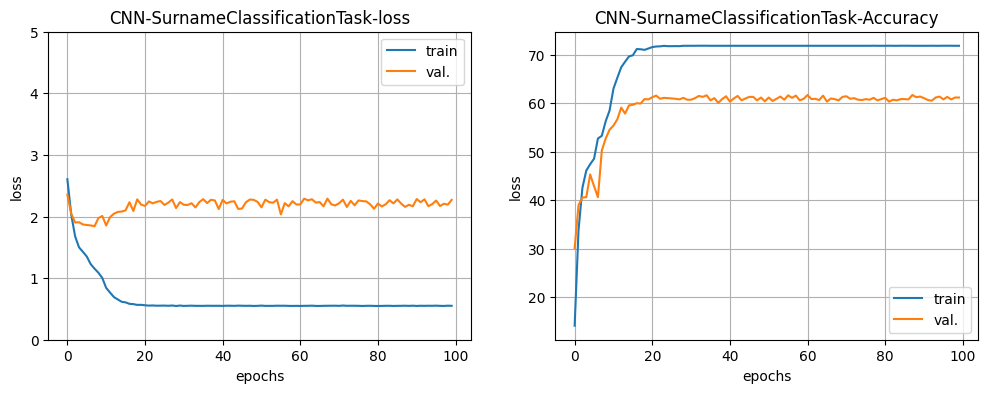

In [65]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot(
    targets=(train_state["train_loss"], train_state["val_loss"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[0, 5],
    grid = True,
    title = "CNN-SurnameClassificationTask-loss",
    legend=True
    )
plt.subplot(122)
plot(
    targets=(train_state["train_acc"], train_state["val_acc"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    grid = True,
    title = "CNN-SurnameClassificationTask-Accuracy",
    legend=True
    )
plt.show()